# Performance as a function focal plane position

Authors: Keith Bechtol and Angelo Fausti

Date: 31 May 2018

Stack Version: weekly 2018_21

The goal of this notebook is to demonstrate methods to compile performance metrics from a set of individual visits and assemble as a function focal plane position (sensor number or x,y position in instrument coordinates). 

Unfortunately, it takes about a minute to read the `src` entries from a single visit, so it will take some patience to aggregate statistics from many visits.

In [2]:
import numpy as np
import pandas as pd

import lsst.daf.persistence as daf_persistence

%matplotlib inline
import matplotlib.pyplot as plt

### HSC PDR1

Information available here: https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

The output repos are:
* /datasets/hsc/repo/rerun/DM-13666/UDEEP/
* /datasets/hsc/repo/rerun/DM-13666/DEEP/
* /datasets/hsc/repo/rerun/DM-13666/WIDE/

Note that each of the data repositories contains all of the HSC visits, so one has to select by field to get the visits corresponding to a particular Strategic Survey Program (SSP) survey.

In [3]:
band = 'HSC-R'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE'
outfile = 'focal_plane_df.h5'
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


As a side note, you can find out all of the SSP field names with the following command

In [4]:
unique_visits = butler.queryMetadata('src', ['field'])
[ field for field in unique_visits if 'SSP' in field ]

['SSP_WIDE',
 'SSP_UDEEP_SXDS',
 'SSP_UDEEP_COSMOS',
 'SSP_DEEP_DEEP2_3',
 'SSP_AEGIS',
 'SSP_DEEP_COSMOS',
 'SSP_DEEP_ELAIS_N1',
 'SSP_DEEP_XMM_LSS',
 'SSP_DEEP_XMMS_LSS']

In [5]:
unique_visits = butler.queryMetadata('src', ['visit'], dataId={'filter':band, 'field':field})
print('Found %i unique visits in %s band %s depth survey'%(len(unique_visits), band, depth))

Found 818 unique visits in HSC-R band WIDE depth survey


In [6]:
subset = butler.subset('src', dataId={'filter':band, 'field':field})

In [49]:
#butler.get('src', dataId=subset.cache[0]).schema.getNames()

Looping over the individual visits and saving the columns of interest into a merged pandas dataframe

In [118]:
%%time

restricted_columns = ['coord_ra','coord_dec',
                      'slot_Centroid_x','slot_Centroid_y',
                      'base_FPPosition_x', 'base_FPPosition_y',
                      'slot_PsfFlux_flux',
                      'slot_PsfShape_xx', 'slot_PsfShape_yy', 'slot_PsfShape_xy',
                      'slot_Shape_xx', 'slot_Shape_yy', 'slot_Shape_xy',
                      'calib_astrometryUsed',
                      'calib_detected',
                      'calib_photometry_reserved',
                      'calib_photometry_used',
                      'calib_psfCandidate',
                      'calib_psfUsed',
                      'calib_psf_reserved',
                      'base_ClassificationExtendedness_value']

if True:
    df_array = [] 
    visits = unique_visits[0:1]
    #visits = unique_visits[0:10]
    for dataid in subset.cache:
        if dataid['visit'] in visits and butler.datasetExists('src', dataid):
            print("Loading Visit: {}, CCD: {}".format(dataid['visit'], dataid['ccd']))
            df_full = butler.get('src', dataid).asAstropy().to_pandas()
            df = df_full[restricted_columns]
            df['visit'] = dataid['visit']
            df['ccd'] = dataid['ccd']
            df_array.append(df)

    df = pd.concat(df_array)

Loading Visit: 7110, CCD: 89


/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading Visit: 7110, CCD: 32
Loading Visit: 7110, CCD: 39
Loading Visit: 7110, CCD: 5
Loading Visit: 7110, CCD: 61
Loading Visit: 7110, CCD: 59
Loading Visit: 7110, CCD: 47
Loading Visit: 7110, CCD: 75
Loading Visit: 7110, CCD: 101
Loading Visit: 7110, CCD: 63
Loading Visit: 7110, CCD: 36
Loading Visit: 7110, CCD: 25
Loading Visit: 7110, CCD: 58
Loading Visit: 7110, CCD: 97
Loading Visit: 7110, CCD: 14
Loading Visit: 7110, CCD: 99
Loading Visit: 7110, CCD: 26
Loading Visit: 7110, CCD: 91
Loading Visit: 7110, CCD: 30
Loading Visit: 7110, CCD: 4
Loading Visit: 7110, CCD: 60
Loading Visit: 7110, CCD: 34
Loading Visit: 7110, CCD: 21
Loading Visit: 7110, CCD: 6
Loading Visit: 7110, CCD: 10
Loading Visit: 7110, CCD: 8
Loading Visit: 7110, CCD: 72
Loading Visit: 7110, CCD: 31
Loading Visit: 7110, CCD: 84
Loading Visit: 7110, CCD: 45
Loading Visit: 7110, CCD: 37
Loading Visit: 7110, CCD: 94
Loading Visit: 7110, CCD: 48
Loading Visit: 7110, CCD: 64
Loading Visit: 7110, CCD: 24
Loading Visit: 71

Save this merged pandas dataframe to an HDF5 file, so we don't have to re-run

In [50]:
#df.to_hdf(outfile, 'df')

Shortcut is to read the output file

In [145]:
#df = pd.read_hdf(outfile, 'df')

In [146]:
print(df.shape)
print(list(df.columns.values))

(1107421, 25)
['coord_ra', 'coord_dec', 'slot_Centroid_x', 'slot_Centroid_y', 'base_FPPosition_x', 'base_FPPosition_y', 'slot_PsfFlux_flux', 'slot_PsfShape_xx', 'slot_PsfShape_yy', 'slot_PsfShape_xy', 'slot_Shape_xx', 'slot_Shape_yy', 'slot_Shape_xy', 'calib_astrometryUsed', 'calib_detected', 'calib_photometry_reserved', 'calib_photometry_used', 'calib_psfCandidate', 'calib_psfUsed', 'calib_psf_reserved', 'base_ClassificationExtendedness_value', 'visit', 'ccd', 'psf_trace_radius', 'psf_determinant_radius']


Define some measures of image quality, such as PSF sizes and ellipticities

In [147]:
xx = df.slot_PsfShape_xx
yy = df.slot_PsfShape_yy
xy = df.slot_PsfShape_xy
df['psf_trace_radius'] = np.sqrt((xx + yy) / 2.)
df['psf_determinant_radius'] = (xx * yy - xy * xy)**(1. / 4.)

In [148]:
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.
    Parameters
    ----------
    I_xx : float
    I_xy : float
    I_yy : float
    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
    """

    #e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*np.sqrt(I_xx*I_yy - I_xy*2))
    e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*np.sqrt(I_xx*I_yy - I_xy**2))
    e1 = e.real
    e2 = e.imag
    return e, e1, e2

In [149]:
#restricted_columns = ['']
#sources_df.query(cut)[restricted_columns]
df_stars = df.query('base_ClassificationExtendedness_value == 0')
#df_stars = df.query('calib_psf_reserved == 1')
print(len(df_stars))
print(len(df_stars.slot_Shape_xx))
e, e1, e2 = ellipticity(df_stars.slot_Shape_xx, df_stars.slot_Shape_xy, df_stars.slot_Shape_yy)
df_stars['e1'] = e1
df_stars['e2'] = e2

e, e1, e2 = ellipticity(df_stars.slot_PsfShape_xx, df_stars.slot_PsfShape_xy, df_stars.slot_PsfShape_yy)
df_stars['e1_psf'] = e1
df_stars['e2_psf'] = e2

288349
288349


/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Now some plots

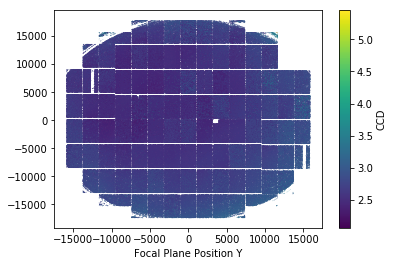

In [172]:
plt.figure()
#c = df.ccd
#c = df.base_PixelFlags_flag_edge
c = df.psf_trace_radius
plt.scatter(df.base_FPPosition_x, df.base_FPPosition_y, c=c, edgecolor='none', marker='.', s=1)
plt.colorbar(label='CCD')
plt.xlabel('Focal Plane X')
plt.xlabel('Focal Plane Y')

(array([2.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+01, 8.00000e+00,
        1.10000e+01, 1.40000e+01, 1.10000e+01, 1.50000e+01, 2.00000e+01,
        2.70000e+01, 2.90000e+01, 3.30000e+01, 3.60000e+01, 6.20000e+01,
        6.70000e+01, 7.40000e+01, 7.30000e+01, 1.08000e+02, 1.10000e+02,
        1.15000e+02, 8.50000e+01, 1.23000e+02, 1.51000e+02, 1.67000e+02,
        1.73000e+02, 1.81000e+02, 2.57000e+02, 2.54000e+02, 3.04000e+02,
        3.69000e+02, 4.73000e+02, 5.85000e+02, 6.61000e+02, 7.50000e+02,
        9.11000e+02, 1.06900e+03, 1.25100e+03, 1.59100e+03, 1.76300e+03,
        2.12600e+03, 2.47500e+03, 2.98000e+03, 3.48400e+03, 4.23000e+03,
        5.26000e+03, 6.54800e+03, 8.59400e+03, 1.26200e+04, 2.35700e+04,
        1.02518e+05, 3.78270e+04, 1.50140e+04, 9.51000e+03, 6.91200e+03,
        5.58200e+03, 4.35400e+03, 3.69800e+03, 3.00800e+03, 2.68400e+03,
        2.15600e+03, 1.87100e+03, 1.56800e+03, 1.28600e+03, 1.09500e+03,
        9.36000e+02, 7.51000e+02, 5.85000e+02, 5.61

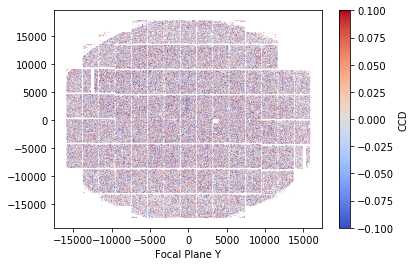

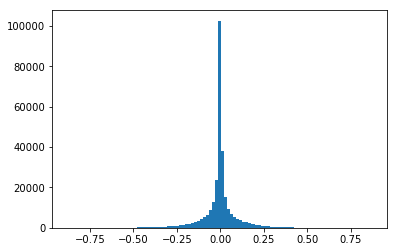

In [173]:
plt.figure()
c = df_stars.e1 - df_stars.e1_psf
plt.scatter(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, c=c, 
            edgecolor='none', marker='.', s=1, cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar(label='CCD')
plt.xlabel('Focal Plane X')
plt.xlabel('Focal Plane Y')

plt.figure()
plt.hist(c, bins=101)

We want to bin the performance metrics by instrument coordinates to more easily visualize sublte variations over the focal plane. The cell below performs a simple average each each bin.

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


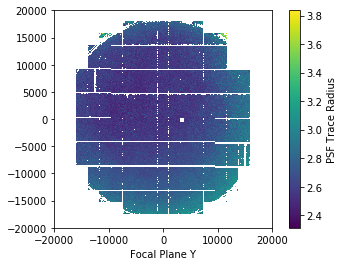

In [171]:
bins = np.linspace(-20000, 20000, 401)
counts = np.histogram2d(df.base_FPPosition_x, df.base_FPPosition_y, bins=[bins, bins])[0]
weights = np.histogram2d(df.base_FPPosition_x, df.base_FPPosition_y, bins=[bins, bins], weights=df.psf_trace_radius)[0]
mean = (weights / counts).T
plt.figure()
plt.imshow(mean, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower')
plt.colorbar().set_label('PSF Trace Radius')
plt.xlim(bins[0], bins[-1])
plt.ylim(bins[0], bins[-1])
plt.xlabel('Focal Plane X')
plt.xlabel('Focal Plane Y')

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


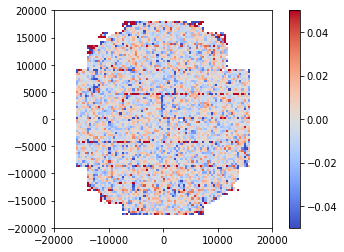

In [154]:
bins = np.linspace(-20000, 20000, 101)
z = df_stars.e1 - df_stars.e1_psf
#z = df_stars.e2
counts = np.histogram2d(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, bins=[bins, bins])[0]
weights = np.histogram2d(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, bins=[bins, bins], 
                         weights=z)[0]
mean = (weights / counts).T
plt.figure()
plt.imshow(mean, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', vmin=-0.05, vmax=0.05, cmap='coolwarm')
plt.xlim(bins[0], bins[-1])
plt.ylim(bins[0], bins[-1])
plt.colorbar()

This plot is work in progress (something is clearly wrong). Still learning how to make a whisker plot.

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


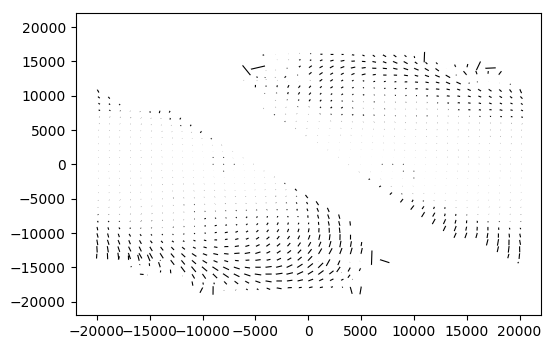

Help on function quiver in module matplotlib.pyplot:

quiver(*args, **kw)
    Plot a 2-D field of arrows.
    
    Call signatures::
    
      quiver(U, V, **kw)
      quiver(U, V, C, **kw)
      quiver(X, Y, U, V, **kw)
      quiver(X, Y, U, V, C, **kw)
    
    *U* and *V* are the arrow data, *X* and *Y* set the locaiton of the
    arrows, and *C* sets the color of the arrows. These arguments may be 1-D or
    2-D arrays or sequences.
    
    If *X* and *Y* are absent, they will be generated as a uniform grid.
    If *U* and *V* are 2-D arrays and *X* and *Y* are 1-D, and if ``len(X)`` and
    ``len(Y)`` match the column and row dimensions of *U*, then *X* and *Y* will be
    expanded with :func:`numpy.meshgrid`.
    
    The default settings auto-scales the length of the arrows to a reasonable size.
    To change this behavior see the *scale* and *scale_units* kwargs.
    
    The defaults give a slightly swept-back arrow; to make the head a
    triangle, make *headaxislength* the

In [169]:
bins = np.linspace(-20000, 20000, 41)
X, Y = np.meshgrid(bins, bins)

counts = np.histogram2d(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, bins=[bins, bins])[0]
weights = np.histogram2d(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, bins=[bins, bins], 
                         weights=df_stars.e1_psf)[0]
U = (weights / counts).T

counts = np.histogram2d(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, bins=[bins, bins])[0]
weights = np.histogram2d(df_stars.base_FPPosition_x, df_stars.base_FPPosition_y, bins=[bins, bins], 
                         weights=df_stars.e2_psf)[0]
V = (weights / counts).T

plt.figure(dpi=100)
#q = plt.quiver(X, Y, U, V, color=np.sqrt(U**2 + V**2), pivot='middle', angles='uv', headwidth=0)
q = plt.quiver(X, Y, U, V, pivot='middle', angles='uv', headwidth=0)
#plt.quiverkey(q, X=0.3, Y=1.1, U=10,
#             label='Quiver key, length = 10', labelpos='E')

plt.show()
help(plt.quiver)

# Code Scraps

In [7]:
"""
#subset = butler.subset('calexp', **{'filter':band, 'visit':unique_visits[0]})
#for ii in range(0, len(subset.cache)):
#    src = butler.get('src', **subset.cache[ii])
#butler.queryMetadata('calexp', ['visit', 'ccd', 'filter'], dataId={'filter':band, 'visit':unique_visits[0]})

n_visits = 2
df_array = []
for ii in range(0, n_visits):
    print('Visit = %i'%(unique_visits[ii]))
    df_array.append(getSrcFullFocalPlane(unique_visits[ii], band))
    #src = butler.get('src', dataId={'visit':unique_visits[ii], 'filter':band, 'ccd':0})
    
df = pd.concat(df_array)
"""

"\n#subset = butler.subset('calexp', **{'filter':band, 'visit':unique_visits[0]})\n#for ii in range(0, len(subset.cache)):\n#    src = butler.get('src', **subset.cache[ii])\n#butler.queryMetadata('calexp', ['visit', 'ccd', 'filter'], dataId={'filter':band, 'visit':unique_visits[0]})\n\nn_visits = 2\ndf_array = []\nfor ii in range(0, n_visits):\n    print('Visit = %i'%(unique_visits[ii]))\n    df_array.append(getSrcFullFocalPlane(unique_visits[ii], band))\n    #src = butler.get('src', dataId={'visit':unique_visits[ii], 'filter':band, 'ccd':0})\n    \ndf = pd.concat(df_array)\n"

In [6]:
"""
def getSrcFullFocalPlane(visit, band):
    subset = butler.subset('src', **{'filter':band, 'visit':visit})
    #print(len(subset.cache))
    df_array =[]
    for dataid in subset.cache:
        if butler.datasetExists('src', dataId=dataid):
            #print('It exists:', dataid['ccd'])
            src = butler.get('src', dataId=dataid)
            df_array.append(src.asAstropy().to_pandas())
            #data = {'x': src.getX(),
            #        'y': src.getY()}
            #df_array.append(pd.DataFrame(data=data))
            #df_array[-1] = df_array[-1].assign(visit = dataid['visit'])
            #df_array[-1] = df_array[-1].assign(ccd = dataid['ccd'])
            df_array[-1]['visit'] = dataid['visit']
            df_array[-1]['ccd'] = dataid['ccd']
        else:
            pass
            #print('No go:', dataid['ccd'])
            
    return pd.concat(df_array)
"""

"\ndef getSrcFullFocalPlane(visit, band):\n    subset = butler.subset('src', **{'filter':band, 'visit':visit})\n    #print(len(subset.cache))\n    df_array =[]\n    for dataid in subset.cache:\n        if butler.datasetExists('src', dataId=dataid):\n            #print('It exists:', dataid['ccd'])\n            src = butler.get('src', dataId=dataid)\n            df_array.append(src.asAstropy().to_pandas())\n            #data = {'x': src.getX(),\n            #        'y': src.getY()}\n            #df_array.append(pd.DataFrame(data=data))\n            #df_array[-1] = df_array[-1].assign(visit = dataid['visit'])\n            #df_array[-1] = df_array[-1].assign(ccd = dataid['ccd'])\n            df_array[-1]['visit'] = dataid['visit']\n            df_array[-1]['ccd'] = dataid['ccd']\n        else:\n            pass\n            #print('No go:', dataid['ccd'])\n            \n    return pd.concat(df_array)\n"